d:\Users\jg255\anaconda3\envs\ray310\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
d:\Users\jg255\anaconda3\envs\ray310\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


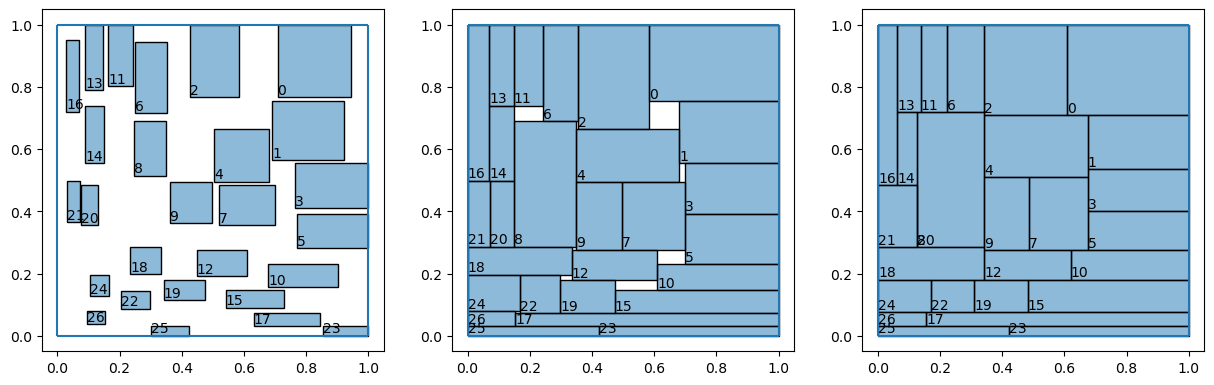

In [5]:
from SquareDivision.src.rectangle_class import Rectangulation

rects = Rectangulation(config={'seed' : 1234567})
rects.execute(num=100)
rects.prepare_constraints()
rects.close_holes()
rects.draw_closed()

In [36]:
import numpy as np
from scipy.optimize import NonlinearConstraint
from SquareDivision.holes.detect import hole_closing_idxs
from SquareDivision.optimization.constraints import contacts_after_hole_closing, hole_closing_jac
import copy
clinched_rectangles:np.ndarray

holes_constraints = []
for idxs_to_close in rects.holes_idxs:
    # rects.holes_idxs
    # idxs_to_close = hole_closing_idxs(hole, clinched_rectangles)
    holes_constraints.append(
        NonlinearConstraint(
            fun=lambda x, hole_closing_idxs=idxs_to_close : contacts_after_hole_closing(x, hole_closing_idxs),
            jac=lambda x, hole_closing_idxs=idxs_to_close : hole_closing_jac(x, hole_closing_idxs),
            lb=0, ub=0)
    )

In [39]:
for constraint in holes_constraints:
    constraint:NonlinearConstraint
    print(constraint.fun(rects.clinched_rectangles[:,:4].flatten()))
# FIX to nie moze byc to samo, dla róznych diur ma byc inaczej 

[0.01148791]
[0.00063912]
[0.00520946]
[0.00514772]
[0.00153831]
[0.00259183]
[0.00172143]
[0.00408787]
[0.00190866]
[4.8893288e-05]
[0.00225834]
[0.00040549]
[0.00201757]
[0.00019844]


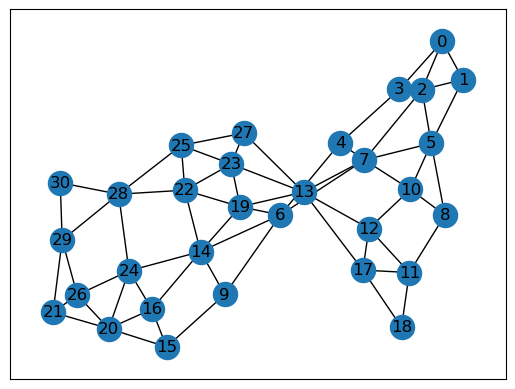

In [ ]:
import networkx as nx
from SquareDivision.holes.detect import graph_from_neighbours_arrays
north_graph = graph_from_neighbours_arrays(north_neighbours, 0)
all_graph = graph_from_neighbours_arrays(north_neighbours, east_neighbours)
# nx.draw_networkx(north_graph,pos=nx.spring_layout(north_graph))
nx.draw_networkx(all_graph)#|, pos=nx.spring_layout(all_graph))

## Projection onto retrangulation without holes

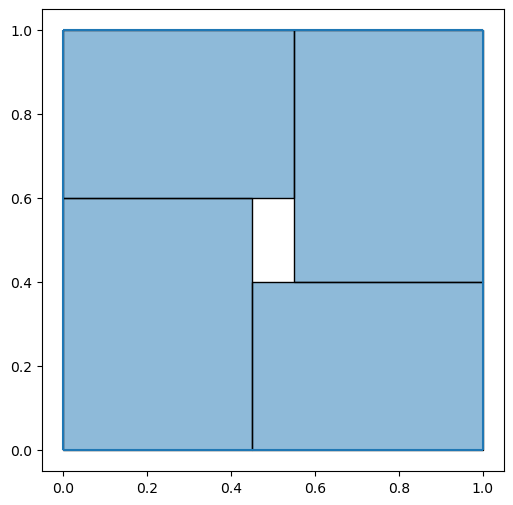

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles


width, height = np.array([0.1, 0.2]) / 2
rect_area = (0.5 - width)*(0.5 + height)
arr_with_hole = np.array([
    [          0,            0, 0.5 - width, 0.5 + height, (0.5 - width) * (0.5 + height)],
    [          0, 0.5 + height, 0.5 + width, 0.5 - height, (0.5 + width) * (0.5 - height)],
    [0.5 + width, 0.5 - height, 0.5 - width, 0.5 + height, (0.5 - width) * (0.5 + height)],
    [0.5 - width,            0, 0.5 + width, 0.5 - height, (0.5 + width) * (0.5 - height)],
])
#additional name for future
clinched_rectangles = arr_with_hole
fig, ax = plt.subplots(figsize=(6, 6))
ax = draw_rectangles(ax, arr_with_hole)
plt.show()

east_neighbours = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0]
])
north_neighbours = np.array([
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0]
])

In [ ]:
arr_with_hole

array([[0.  , 0.  , 0.4 , 0.55, 0.22],
       [0.  , 0.55, 0.6 , 0.45, 0.27],
       [0.6 , 0.45, 0.4 , 0.55, 0.22],
       [0.4 , 0.  , 0.6 , 0.45, 0.27]])

### condition building on `[x, y, width, height, area]` such that:
sum of areas is 1, apropriate sums of height and width are 1, first build matrix `A`

In [ ]:
east_neighbours = np.array([
    [0,0,0,1],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,0]
])
north_neighbours = np.array([
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,1,0]
])


#### bounds

In [ ]:
def bounds_from_clinched(clinched_rectangles:np.ndarray):
    n, m = clinched_rectangles.shape
    lb = np.zeros(shape= n * 5)
    ub = np.ones(shape= n * 5)
    for num, row in enumerate(clinched_rectangles):
        idx = 5 * num
        if np.isclose(row[0], 0) and np.isclose(row[1], 0): 
            lb[idx], ub[idx], lb[idx+1], ub[idx+1] = 0, 0, 0, 0
            continue # keep (0,0) corner
        elif np.isclose(row[0], 0) and (not np.isclose(row[1], 0)):
            lb[idx], ub[idx] = 0, 0 
            continue # keep-left
        elif (not np.isclose(row[0], 0)) and np.isclose(row[1], 0):
            lb[idx+1], ub[idx+1] = 0, 0
            continue # keep-bottom
        else:
            continue
    return lb, ub
        

In [ ]:
from scipy.optimize import Bounds
lb, ub = bounds_from_clinched(clinched_rectangles)
bounds = Bounds(lb=lb, ub=ub, keep_feasible=np.array([True]*20))

#### New functions fo constraints

In [ ]:
from scipy.optimize import LinearConstraint, NonlinearConstraint
from SquareDivision.optimization.constraints import (
    low_boundary_constraint_args,
    high_boundary_constraint_args,
    contact_constraint_args,
    area_constraint_fun,
    area_jac
)
from SquareDivision.optimization.objective_function import (
    dist_fun
)
from SquareDivision.optimization.initial_guess import (
    contact_universal_x0
)

In [ ]:
clinched_rectangles = clinched_rectangles[:,:4]
low__X_A, low__X_rhs = low_boundary_constraint_args(clinched_rectangles, east_neighbours, axis=0)
low__Y_A, low__Y_rhs = low_boundary_constraint_args(clinched_rectangles, north_neighbours, axis=1)
high_X_A, high_X_rhs = high_boundary_constraint_args(clinched_rectangles, east_neighbours, axis=0)
high_Y_A, high_Y_rhs = high_boundary_constraint_args(clinched_rectangles, north_neighbours, axis=1)
low__X_constr = LinearConstraint( A=low__X_A, lb=low__X_rhs, ub=low__X_rhs)
low__Y_constr = LinearConstraint( A=low__Y_A, lb=low__Y_rhs, ub=low__Y_rhs)
high_X_constr = LinearConstraint( A=high_X_A, lb=high_X_rhs, ub=high_X_rhs)
high_Y_constr = LinearConstraint( A=high_Y_A, lb=high_Y_rhs, ub=high_Y_rhs)

cont_X_A, cont_X_rhs = contact_constraint_args(clinched_rectangles, east_neighbours, axis=0)
cont_Y_A, cont_Y_rhs = contact_constraint_args(clinched_rectangles, north_neighbours, axis=1)
horizontal_contacts = LinearConstraint( A=cont_X_A, lb=cont_X_rhs, ub=cont_X_rhs)
vertical___contacts = LinearConstraint( A=cont_Y_A, lb=cont_Y_rhs, ub=cont_Y_rhs)

area_constr = NonlinearConstraint(fun=area_constraint_fun, jac=area_jac, lb=0, ub=0)
constraints = [
    low__X_constr, low__Y_constr,
    high_X_constr, high_Y_constr,
    horizontal_contacts,
    vertical___contacts,
    area_constr].extend(holes_constraints)

x0 = contact_universal_x0(clinched_rectangles=clinched_rectangles).flatten()

In [ ]:
from scipy.optimize import minimize
# x0 = build_x0(arr_with_hole)
# x0 = x0_cross_ab(0.2,0.3)
# x0 = contact_universal_x0(clinched_rectangles).flatten()
sol = minimize(dist_fun, x0=x0, args=(clinched_rectangles), jac=True, method='trust-constr', constraints=constraints)#, bounds=bounds)

In [4]:
rects.sol#.x.reshape(-1,4)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 0.05858546985256471
                x: [ 7.524e-01  5.675e-01 ...  6.828e-02  3.183e-02]
              nit: 27
             nfev: 25
             njev: 25
             nhev: 0
         cg_niter: 0
     cg_stop_cond: 1
             grad: [ 2.420e-02 -5.174e-02 ... -2.678e-02  2.639e-03]
  lagrangian_grad: [ 8.698e-04 -4.835e-02 ...  6.548e-04  2.724e-03]
           constr: [array([ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                           0.000e+00]), array([ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                           0.000e+00]), array([ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                           0.000e+00]), array([ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                           0.000e+00]), array([-5.551e-17, -5.551e-17, ..., -6.939e-18,
                           1.388e-17]), array([ 0.000e+00,  2.776e-17, ...,  0.000e+00,
          

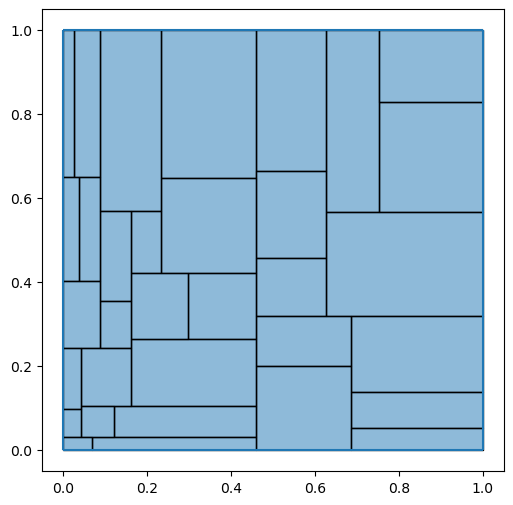

In [7]:
import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles
rects_sol = rects.sol.x.reshape(-1,4)
fig, ax = plt.subplots(figsize=(6, 6))
# ax = draw_rectangles(ax, np.c_[rects_sol,np.array([0,0,0,0])])
# ax = draw_rectangles(ax, clinched_rectangles)
ax = draw_rectangles(ax, rects_sol)

plt.show()

In [ ]:
(rects_sol[:,2]*rects_sol[:,3]).sum()

0.9721516226985573

#### minimizing with SLSQP

In [5]:
from SquareDivision.optimization.constraints import constraints_SLSQP
from SquareDivision.optimization.objective_function import (
    dist_fun
)
constraints_for_SLSQP = constraints_SLSQP(clinched_rectangles,east_neighbours, north_neighbours, holes)

In [6]:
from scipy.optimize import minimize
sol = minimize(dist_fun, x0=clinched_rectangles.flatten(), args=(clinched_rectangles), jac=True, method='slsqp', constraints=constraints_for_SLSQP)#, bounds=bounds)

ValueError: negative dimensions are not allowed